# Rosenbrock landscape

The Rosenbrock function is a typical non-convex bivariate that is commonly used to benchmark optimisation routines.

$$
f(x,y) = (1-x)^2 + 100(y-x^2)^2
$$

Here we explore 1 and 2 downhill neighbour pathways on an unstructured mesh using this function.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from quagmire import SurfaceProcessMesh
from quagmire import tools as meshtools
%matplotlib inline

In [2]:
minX, maxX = -2.0, 2.0
minY, maxY = -2.0, 3.0

x, y, bmask = meshtools.square_mesh(minX, maxX, minY, maxY, 0.05, 0.05, samples=10000, boundary_samples=1000)
x, y = meshtools.lloyd_mesh_improvment(x, y, bmask, 5)

# x_new = np.zeros(500)
# y_new = np.zeros(500) + np.random.uniform(-2, 0.1)
# x = np.append(x, x_new)
# y = np.append(y, y_new)

height = (1.0 - x)**2 + 100.0*(y - x**2)**2 # Rosenbrock function
# height[height < 50] = 50.
height -= 100*y # make a small incline

dm = meshtools.create_DMPlex_from_points(x, y, bmask)
sp = SurfaceProcessMesh(dm)
sp.update_height(height)

 - Delaunay triangulation 0.173729s
 - Compute edge lengths 0.023547s
 - Construct neighbour array 0.111888s
 - Find boundaries 0.037954s
 - Build smoothing matrix 0.055163s
 - Sort nodes by field 0.049637s
 - Build downhill matrices 0.155666s


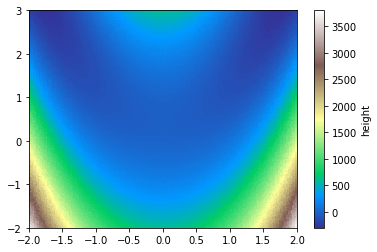

In [3]:
fig = plt.figure(1)
ax = fig.add_subplot(111, xlim=(minX, maxX), ylim=(minY, maxY))
im = ax.tripcolor(x, y, sp.tri.simplices, height, cmap='terrain')
fig.colorbar(im, ax=ax, label='height')
plt.show()

In [4]:
def compute_stream_power(self):
    """ Compute stream power """
    rainflux = self.rainfall_pattern
    rainfall = self.area * rainflux
    cumulative_rain = self.cumulative_flow(rainfall)
    cumulative_flow_rate = cumulative_rain / self.area
    return cumulative_flow_rate * self.slope

def compute_cumulative_flow_rate(self):
    rainflux = self.rainfall_pattern
    rainfall = self.area * rainflux
    cumulative_rain = self.cumulative_flow(rainfall)
    cumulative_flow_rate = cumulative_rain / self.area
    return cumulative_flow_rate

## Compare one and two downhill pathways

The Rosenbrock function encapsulates a Y-junction where a river splits in two.

In [8]:
sp._build_downhill_matrix()
down2 = sp.downhillMat.copy() # 2 downhill neighbours

sp._build_adjacency_matrix_1() 
down1 = sp.adjacency1.copy() # 1 downhill neighbour

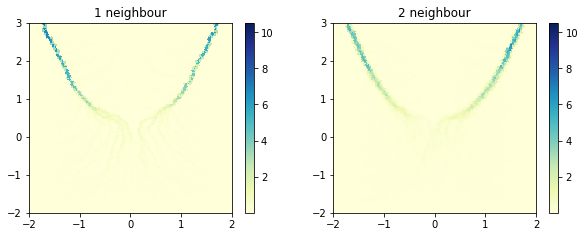

In [17]:
upstream_area = np.empty((2, sp.npoints))

for i, downhillMat in enumerate([down1, down2]):
    sp.downhillMat = downhillMat
    upstream_area[i] = sp.cumulative_flow(sp.area)

max_uparea = upstream_area.max()

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,3.5))

for i, ax in enumerate([ax1,ax2]):
    ax.set_xlim(minX, maxX)
    ax.set_ylim(minY, maxY)
    ax.set_title('{} neighbour'.format(i+1))

    im = ax.tripcolor(x, y, sp.tri.simplices, upstream_area[i], vmax=max_uparea, cmap='YlGnBu')
    fig.colorbar(im, ax=ax)

A finite volume of water is propagated downstream where a single stream meets a Y-junction and the river must diverge.

In [18]:
rain = np.zeros_like(height)
rain[np.logical_and(x > -0.1, x < 0.1)] = 10.
rain[y > 0.] = 0.0

smooth_rain = sp.local_area_smoothing(rain, its=10)

In [21]:
# Create some movies!
import matplotlib.animation as manimation
FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title='Movie Test', artist='Matplotlib',
        comment='Movie support!')
writer = FFMpegWriter(fps=24, codec='libx264', bitrate=2000, metadata=metadata)

DX0 = sp.gvec.duplicate()
DX1 = sp.gvec.duplicate()

for i, downhillMat in enumerate([down1, down2]):
    sp.downhillMat = downhillMat
    DX0.set(0.0)
    DX1.setArray(smooth_rain)
    
    plt.ion()
    
    fig = plt.figure(1)
    ax1 = fig.add_subplot(111, xlim=[minX,maxX], ylim=[minY,maxY])
    ax1.axes.set_aspect("equal")
    ax1.axis('off')
    ax1.tripcolor(x, y, sp.tri.simplices, height, cmap='YlOrRd', shading='gouraud', zorder=0)
    im1 = ax1.tripcolor(x, y, sp.tri.simplices, DX1.array, vmax=1, cmap='Blues', shading='gouraud', alpha=0.5, zorder=1)
    
    step = 0
    with writer.saving(fig, 'rosenbrock_{}n.mp4'.format(i+1), 100):
        while DX1.array.any():
            im1.set_array(DX1.array)
            fig.canvas.draw()
            writer.grab_frame()

            if step%10 == 0:
                print "{} neighbour - step {:04d} -  remaining information {:.6f}".format(i+1, step, DX1.sum())

            step += 1

            DX1 = sp.downhillMat*DX1
            DX0 += DX1
    plt.close()

1 neighbour - step 0000 -  remaining information 6233.085164
1 neighbour - step 0010 -  remaining information 6233.085164
1 neighbour - step 0020 -  remaining information 6233.085164
1 neighbour - step 0030 -  remaining information 6233.085164
1 neighbour - step 0040 -  remaining information 6233.085164
1 neighbour - step 0050 -  remaining information 6233.085164
1 neighbour - step 0060 -  remaining information 6233.085164
1 neighbour - step 0070 -  remaining information 6231.845504
1 neighbour - step 0080 -  remaining information 5947.877601
1 neighbour - step 0090 -  remaining information 5202.115087
1 neighbour - step 0100 -  remaining information 4422.357737
1 neighbour - step 0110 -  remaining information 3616.107957
2 neighbour - step 0000 -  remaining information 6233.085164
2 neighbour - step 0010 -  remaining information 3933.406750
2 neighbour - step 0020 -  remaining information 3933.406750
2 neighbour - step 0030 -  remaining information 3933.406750
2 neighbour - step 0040 

Downstream flow is better represented using 2 downhill pathways in this example.

### Timestepping

The difference between the choice in number of downhill neighbours may reduce if the landscape is incised and sediments are distributed. We implement Davy and Lague's $\xi - q$ model (no. 3 in "`erosion - deposition models.ipynb`")